[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pronobis/libspn-keras/blob/master/examples/notebooks/Sampling%20with%20conv%20SPNs.ipynb)

# **Image Sampling**: Sampling MNIST images
In this notebook, we'll set up an SPN to generate new MNIST images by sampling from an SPN.

First let's set up the dependencies:

In [38]:
!pip install libspn_keras

Processing ./libspn_keras-0.5.2-py3-none-any.whl


## Convolutional SPN
A convolutional SPN consists of convolutional product and convolutional sum nodes. For the sake of 
demonstration, we'll use a structure that trains relatively quickly, without worrying too much about the final performance of the model. 

In [1]:
import libspn_keras as spnk

### Setting the Default Sum Accumulator Initializer

In `libspn-keras`, we refer to the unnormalized weights as _accumulators_. These can be represented in linear space or logspace. Setting the ``SumOp`` also configures the default choice of representation space for these accumulators. For example, gradients should be used in the case of _discriminative_ learning and accumulators are then preferrably represented in logspace. This overcomes the need to project the accumulators to $\mathbb R^+$ after gradient updates, since for log accumulators can take any value in $\mathbb R$ (whereas linear accumulators are limited to $\mathbb R^+$).

In this case however, we'll do generative learning so we can set our `SumOp` to `SumOpEMBackprop`.

To set the default initial value (which will be transformed to logspace internally if needed), one can use `spnk.set_default_accumulator_initializer`:

In [2]:
from tensorflow import keras

spnk.set_default_accumulator_initializer(
    spnk.initializers.Dirichlet()
)

In [3]:
import numpy as np
import tensorflow_datasets as tfds
from libspn_keras.layers import NormalizeAxes
import tensorflow as tf

def take_first(a, b):
  return tf.reshape(tf.cast(a, tf.float32), (-1, 28, 28, 1))

normalize = spnk.layers.NormalizeStandardScore(
    input_shape=(28, 28, 1), axes=NormalizeAxes.GLOBAL
)

mnist_images = tfds.load(name="mnist", batch_size=32, split="train", as_supervised=True).map(take_first)
normalize.adapt(mnist_images) 
mnist_normalized = np.concatenate(list(mnist_images.map(normalize).as_numpy_iterator()))
location_initializer = spnk.initializers.PoonDomingosMeanOfQuantileSplit(
    mnist_normalized
)


### Defining the Architecture
We'll go for a relatively simple convolutional SPN architecture. We use solely non-overlapping patches. After 5 convolutions, the nodes' scopes cover all variables. We then add a layer with 10 mixtures, one for each class. We can do this to optimize the joint probability of $P(X,Y)$ instead of just $P(X)$.

In [39]:

def build_spn(sum_op, return_logits, infer_no_evidence=False):
  spnk.set_default_sum_op(sum_op)
  return spnk.models.SequentialSumProductNetwork([
    normalize,
    spnk.layers.NormalLeaf(
        num_components=4, 
        location_trainable=True,
        location_initializer=location_initializer,
        scale_trainable=True
    ),
    spnk.layers.Conv2DProduct(
        depthwise=False, 
        strides=[2, 2], 
        dilations=[1, 1], 
        kernel_size=[2, 2],
        padding='valid'
    ),
    spnk.layers.Local2DSum(num_sums=32),
    spnk.layers.Conv2DProduct(
        depthwise=True, 
        strides=[2, 2], 
        dilations=[1, 1], 
        kernel_size=[2, 2],
        padding='valid'
    ),
    spnk.layers.Local2DSum(num_sums=64),
    # Pad to go from 7x7 to 8x8, so that we can apply 3 more Conv2DProducts
    tf.keras.layers.ZeroPadding2D(((0, 1), (0, 1))),
    spnk.layers.Conv2DProduct(
        depthwise=True, 
        strides=[2, 2], 
        dilations=[1, 1], 
        kernel_size=[2, 2],
        padding='valid'
    ),
    spnk.layers.Local2DSum(num_sums=128),
    spnk.layers.Conv2DProduct(
        depthwise=True, 
        strides=[2, 2], 
        dilations=[1, 1], 
        kernel_size=[2, 2],
        padding='valid'
    ),
    spnk.layers.Local2DSum(num_sums=256),
    spnk.layers.Conv2DProduct(
        depthwise=True, 
        strides=[2, 2], 
        dilations=[1, 1], 
        kernel_size=[2, 2],
        padding='valid'
    ),
    spnk.layers.SpatialToRegions(),
    spnk.layers.LogDropout(rate=0.5),
    spnk.layers.DenseSum(num_sums=10),
    spnk.layers.RootSum(return_weighted_child_logits=return_logits)
  ], infer_no_evidence=infer_no_evidence, unsupervised=False)
 

In [40]:
sum_product_network = build_spn(spnk.SumOpEMBackprop(), return_logits=True)
sum_product_network.summary()

Model: "sequential_sum_product_network_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize_standard_score (No (None, 28, 28, 1)         2         
_________________________________________________________________
normal_leaf_8 (NormalLeaf)   (None, 28, 28, 4)         6272      
_________________________________________________________________
conv2d_product_42 (Conv2DPro (None, 14, 14, 256)       4096      
_________________________________________________________________
local2d_sum_30 (Local2DSum)  (None, 14, 14, 32)        1605632   
_________________________________________________________________
conv2d_product_43 (Conv2DPro (None, 7, 7, 32)          4         
_________________________________________________________________
local2d_sum_31 (Local2DSum)  (None, 7, 7, 64)          100352    
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None

### Setting up a `tf.Dataset` with `tensorflow_datasets`
Then, we'll configure a train set and a test set using `tensorflow_datasets`.

In [41]:
import tensorflow_datasets as tfds

batch_size = 128

mnist_train = (
    tfds.load(name="mnist", split="train", as_supervised=True)
    .shuffle(1024)
    .batch(batch_size)
)

mnist_test = (
    tfds.load(name="mnist", split="test", as_supervised=True)
    .batch(100)
)

### Configuring the remaining training components
Note that our SPN spits out the joint probabities for each $y\in\{Y_i\}_{i=1}^{10}$, so there are 10 outputs per sample. We can optimize the probability of $P(X,Y)$ by using `spnk.metrics.NegativeLogJoint` as the loss.

In [44]:
optimizer = spnk.optimizers.OnlineExpectationMaximization(learning_rate=0.05, accumulate_batches=1)
metrics = []
loss = spnk.losses.NegativeLogJoint()

sum_product_network.compile(loss=loss, metrics=metrics, optimizer=optimizer)

### Training the SPN
We can simply use the `.fit` function that comes with Keras and pass our `tf.data.Dataset` to it to train!

In [45]:
import tensorflow as tf 

sum_product_network.fit(mnist_train, epochs=20, callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", min_delta=0.1, patience=2, factor=0.5)])
sum_product_network.evaluate(mnist_test)

Epoch 1/20
469/469 [==============================] - 5s 7ms/step - loss: 402.2145
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 402.2913
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 402.2564
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 401.9757
Epoch 5/20
469/469 [==============================] - 4s 7ms/step - loss: 401.7938
Epoch 6/20
469/469 [==============================] - 4s 7ms/step - loss: 401.7602
Epoch 7/20
469/469 [==============================] - 4s 7ms/step - loss: 401.9316
Epoch 8/20
469/469 [==============================] - 4s 8ms/step - loss: 401.8474
Epoch 9/20
469/469 [==============================] - 4s 7ms/step - loss: 401.7027
Epoch 10/20
469/469 [==============================] - 4s 8ms/step - loss: 401.6992
Epoch 11/20
469/469 [==============================] - 4s 7ms/step - loss: 401.5543
Epoch 12/20
469/469 [==============================] - 3s 7ms/step - loss: 401.7660
E

403.4021911621094

## Building an SPN to sample
For sampling, we require our sum nodes to backpropagate discrete signals that correspond to the sampled paths. Each path originates at the root and eventually ends up at the leaves.

We build using the same function as before and copy the weights from the already trained SPN.

In [47]:
sum_product_network_sample = build_spn(spnk.SumOpSampleBackprop(), return_logits=False, infer_no_evidence=True)
sum_product_network_sample.set_weights(sum_product_network.get_weights())

## Drawing samples
Sampling from SPNs comes down to determining values for variables that are outside of the evidence. When images are sampled as a whole, all variables are omitted from the evidence. For this special case of inference, the `SequentialSumProductNetwork` class defines a `zero_evidence_inference` method that takes a size parameter. Below, we sample 64 images and voilá!

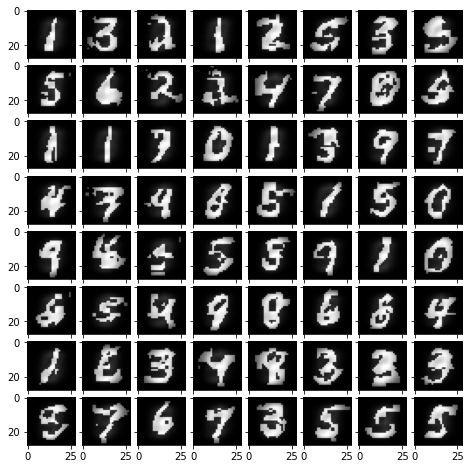

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(
    fig, 111,
    nrows_ncols=(8, 8),
    axes_pad=0.1,
)

sample = sum_product_network_sample.zero_evidence_inference(64)
for ax, im in zip(grid, sample):
    ax.imshow(np.squeeze(im), cmap="gray")
plt.show()